In [ ]:
# Import necessary libraries
import keras
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD
from keras.utils import plot_model
from keras.regularizers import l2

In [ ]:
import os
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate user and mount Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load train and test data from CSV files
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Gesture2Text/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Gesture2Text/Dataset/test.csv')

In [ ]:
# Extract labels and features from train and test data
y_train = train['label'].values
y_test = test['label'].values

X_train = train.drop(['label'],axis=1)
X_test = test.drop(['label'], axis=1)

X_train = np.array(X_train.iloc[:,:])
X_train = np.array([np.reshape(i, (28,28)) for i in X_train])

X_test = np.array(X_test.iloc[:,:])
X_test = np.array([np.reshape(i, (28,28)) for i in X_test])

num_classes = 26
y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

X_train = X_train.reshape((27455, 28, 28, 1))
X_test = X_test.reshape((7172, 28, 28, 1))

In [ ]:
# Define image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    rescale=1./255  # Normalize pixel values
)

datagen.fit(X_train)

In [ ]:
# Define CNN model architecture
classifier = Sequential()
classifier.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
classifier.add(Dropout(0.7))
classifier.add(Flatten())
classifier.add(Dense(256, activation='relu'))
classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(26, activation='softmax'))


In [ ]:
optimizer = Adam(learning_rate=0.0001)
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 20:
        lr *= 0.1
    return lr


In [ ]:
scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
history = classifier.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=50, steps_per_epoch=len(X_train) // 64, validation_data=(X_test, y_test), callbacks=[scheduler])

Epoch 1/50
428/428 [==============================] - 21s 43ms/step - loss: 3.1289 - accuracy: 0.0554 - val_loss: 96.0270 - val_accuracy: 0.0943 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 18s 42ms/step - loss: 2.3875 - accuracy: 0.1868 - val_loss: 346.0078 - val_accuracy: 0.1497 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 18s 43ms/step - loss: 1.6929 - accuracy: 0.3891 - val_loss: 218.0164 - val_accuracy: 0.2617 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 17s 41ms/step - loss: 1.2920 - accuracy: 0.5323 - val_loss: 238.9252 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 17s 40ms/step - loss: 1.0216 - accuracy: 0.6327 - val_loss: 268.2680 - val_accuracy: 0.3406 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 18s 42ms/step - loss: 0.8426 - accuracy: 0.7038 - val_loss: 159.9462 - val_accuracy: 0.4586 - lr: 0.0010
Epoch 7/50
428/428 [===========================

In [ ]:
# Evaluate the model
accuracy = classifier.evaluate(x=X_test, y=y_test, batch_size=64)
print("Accuracy: ", accuracy[1])

113/113 [==============================] - 1s 5ms/step - loss: 49.6102 - accuracy: 0.8109
Accuracy:  0.810931384563446


In [ ]:
# Print model summary
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 128)        

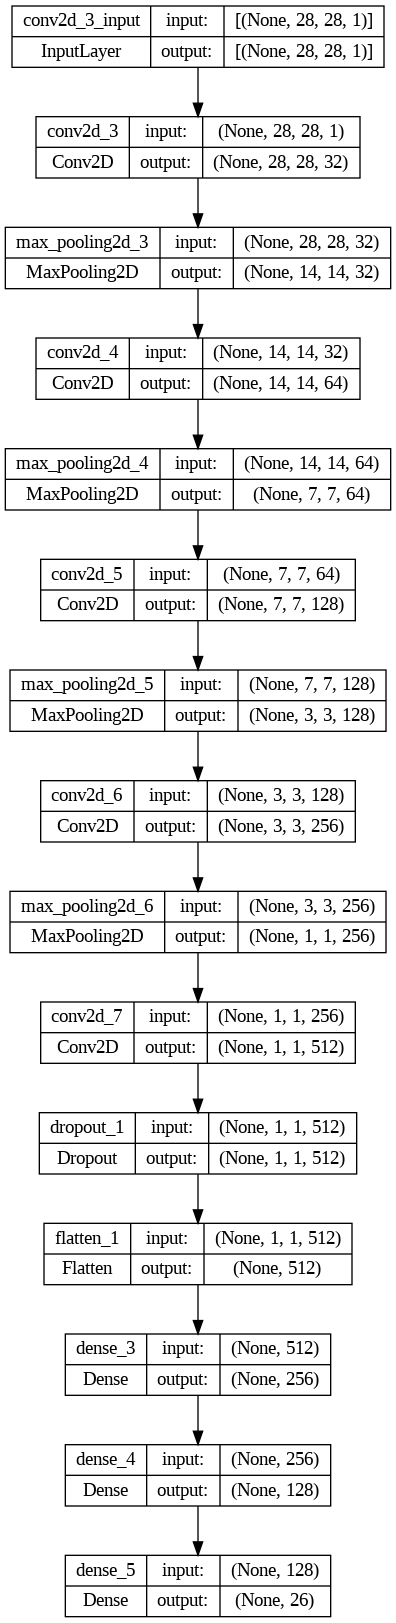

In [ ]:
# Plot model architecture
plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Install necessary dependencies for plotting model
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Double check with Python 3


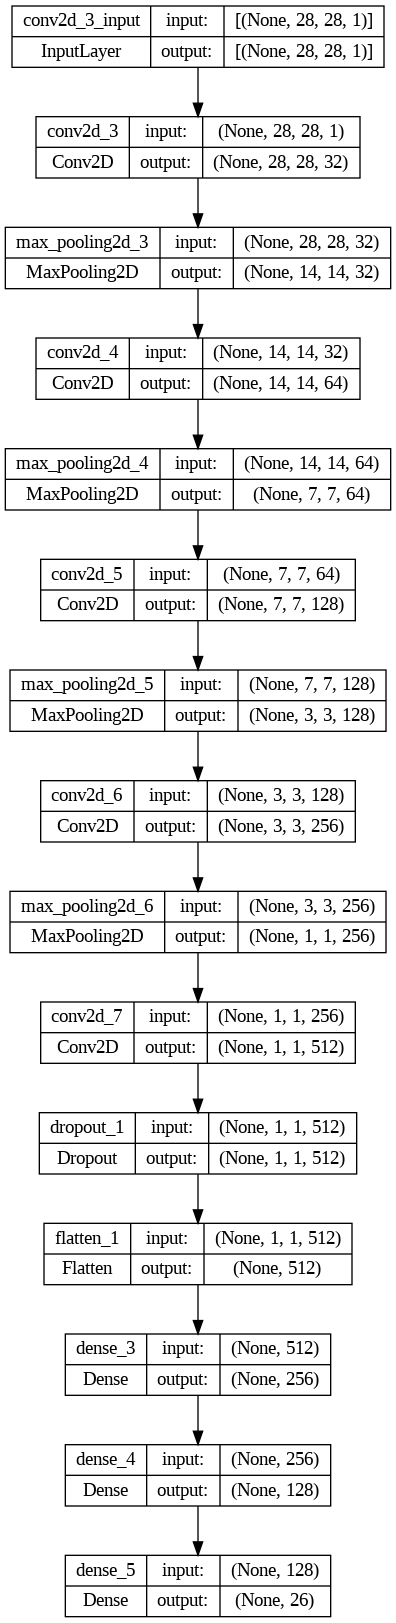

In [ ]:
# Plot and display the model architecture
plot_model(classifier, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
# Save the model to Google Drive
folder_id = 'B3_Iq1qtlLOYxKZ6TUERxdnvnEaigGc'
classifier.save('CNNmodel.h5')
!cp CNNmodel.h5 '/content/drive/MyDrive/Colab Notebooks/Gesture2Text/CNNmodel.h5'